# MASE

In [ ]:
# Check the current python version (It should be using Python 3.11) and update pip to the latest version.
!python3 --version
!python -m pip install --user --upgrade pip

import sys
print(sys.version)

Python 3.11.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.4 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to the file in Google Drive
config_file_path = '/content/drive/My Drive/auth_config.txt'

# Read the token and shortcode
auth_config = {}
with open(config_file_path, 'r') as file:
    for line in file:
        key, value = line.strip().split('=')
        auth_config[key] = value

# Extract token and shortcode
git_token = auth_config.get('token')
short_code = auth_config.get('shortcode')

Mounted at /content/drive


In [ ]:
!git clone https://{git_token}@github.com/DeepWok/mase.git


Cloning into 'mase'...
remote: Enumerating objects: 26658, done.
remote: Counting objects: 100% (3754/3754), done.
remote: Compressing objects: 100% (553/553), done.
remote: Total 26658 (delta 3411), reused 3218 (delta 3198), pack-reused 22904 (from 3)
Receiving objects: 100% (26658/26658), 114.68 MiB | 8.62 MiB/s, done.
Resolving deltas: 100% (17044/17044), done.
Updating files: 100% (1414/1414), done.


In [ ]:
%%bash
# Check if the branch exists. Branch exists, so checkout to that branch otherwise create a new one.
cd mase
# if git show-ref --quiet --verify "refs/heads/lab1_${short_code}"; then
#     # Branch exists, so checkout to that branch
#     git checkout lab1_${short_code}
# else
#     # Branch doesn't exist, so create it
#     git branch lab1_{short_code} git checkout lab1_
# {short_code}
# fi


In [ ]:
%%bash
cd mase
python -m pip install -e . -vvv

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
%cd ./mase/src/

/content/mase/src


# Lab 2.1

## Initialization

In [ ]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

In [ ]:
from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

## 1. Defining the Search Space

In [ ]:
import torch.nn as nn
from chop.nn.modules import Identity


search_space = {
    "num_layers": [2, 4, 8], # Number of transformer layers.
    "num_heads": [2, 4, 8, 16], # Number of attention heads.
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048], # SSize of the feed-forward network (FFN) between transformer blocks
    "linear_layer_type": ["Linear", "Identity"],
}


## 2. Writing a Model Constructor

In [ ]:
def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)
    # The goal is to find the best-performing model configuration by exploring:
    # Model parameters (num_layers, num_heads, hidden_size)
    # Layer types (whether to use nn.Linear or Identity)

    # Sample architecture parameters
    for param in ["num_layers", "num_heads", "hidden_size", "intermediate_size"]:
        chosen_value = trial.suggest_categorical(param, search_space[param])
        # Dynamically update the config object with a chosen value for the parameter sampled by the trial
        setattr(config, param, chosen_value)

    trial_model = AutoModelForSequenceClassification.from_config(config)

    # Ensure layer selection works with GridSampler
    layer_mapping = {
        "Linear": nn.Linear,
        "Identity": Identity,
    }

    # Ensure "linear_layer_type" is properly sampled
    new_layer_str = trial.suggest_categorical("linear_layer_type", search_space["linear_layer_type"])
    new_layer_cls = layer_mapping[new_layer_str]

    # trial_model.named_modules() returns a generator of tuples containing:
    # name: The name of the layer/module (layer1.fc)
    # layer: The actual layer/module object (an nn.Linear or another type of layer)
    # Apply the selected layer type
    for name, layer in trial_model.named_modules():
        # The code looks specifically for layers that are instances of nn.Linear
        # and have the same number of input and output features (in_features == out_features)
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            if new_layer_cls == nn.Linear:
                continue
            elif new_layer_cls == Identity:
                new_layer = Identity() # Removes unnecessary layers Helps determine whether some linear layers contribute to accuracy.
                # deepsetattr replaces the original layer (layer) with the
                # new Identity layer at the correct location in the model.
                deepsetattr(trial_model, name, new_layer)
            else:
                raise ValueError(f"Unknown layer type: {new_layer_cls}")

    return trial_model


## 3. Defining the Objective Function

In [ ]:
from chop.tools import get_trainer


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

## 4. Launching the Search

In [ ]:
import optuna
from optuna.samplers import GridSampler, RandomSampler, TPESampler
import matplotlib.pyplot as plt


# Define samplers to compare
samplers = {
    # "RandomSampler": RandomSampler(),
    "GridSampler": GridSampler(search_space),
    "TPESampler": TPESampler(),
}

# Store results for plotting
results = {}

for sampler_name, sampler in samplers.items():
    # Create a study for each sampler
    study = optuna.create_study(direction="maximize", sampler=sampler)

    # Optimize the objective function
    if sampler_name == "GridSampler":
        study.optimize(objective, n_trials=50)

    else:
        study.optimize(objective, n_trials=50)

    # Track the best accuracy progression
    trial_numbers = [t.number for t in study.trials]
    best_acc = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]

    results[sampler_name] = {
        "trials": trial_numbers,
        "best_acc": best_acc
    }


[I 2025-02-01 11:52:56,170] A new study created in memory with name: no-name-2607cbbc-d2fa-446e-96f2-18bbfe312edc
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.668600
1000,0.504000
1500,0.440400
2000,0.383100
2500,0.336200
3000,0.340600


[I 2025-02-01 11:56:42,191] Trial 0 finished with value: 0.85996 and parameters: {'num_layers': 8, 'num_heads': 2, 'hidden_size': 384, 'intermediate_size': 1536, 'linear_layer_type': 'Linear'}. Best is trial 0 with value: 0.85996.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.690200
1000,0.538800
1500,0.414500
2000,0.371500
2500,0.338000
3000,0.354300


[I 2025-02-01 11:58:47,621] Trial 1 finished with value: 0.85876 and parameters: {'num_layers': 8, 'num_heads': 2, 'hidden_size': 192, 'intermediate_size': 512, 'linear_layer_type': 'Linear'}. Best is trial 0 with value: 0.85996.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.687600
1000,0.538200
1500,0.408600
2000,0.380600
2500,0.339600
3000,0.360800


[I 2025-02-01 12:01:17,365] Trial 2 finished with value: 0.86144 and parameters: {'num_layers': 8, 'num_heads': 8, 'hidden_size': 192, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 2 with value: 0.86144.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.702700
1000,0.665700
1500,0.520700
2000,0.448500
2500,0.416600
3000,0.402500


[I 2025-02-01 12:04:33,043] Trial 3 finished with value: 0.8456 and parameters: {'num_layers': 8, 'num_heads': 16, 'hidden_size': 384, 'intermediate_size': 2048, 'linear_layer_type': 'Identity'}. Best is trial 2 with value: 0.86144.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.692800
1000,0.650600
1500,0.538500
2000,0.474700
2500,0.432600
3000,0.433700


[I 2025-02-01 12:06:40,055] Trial 4 finished with value: 0.82528 and parameters: {'num_layers': 4, 'num_heads': 2, 'hidden_size': 192, 'intermediate_size': 1536, 'linear_layer_type': 'Identity'}. Best is trial 2 with value: 0.86144.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.707200
1000,0.700800
1500,0.673400
2000,0.542800
2500,0.467100
3000,0.447300


[I 2025-02-01 12:10:15,156] Trial 5 finished with value: 0.81592 and parameters: {'num_layers': 8, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 1536, 'linear_layer_type': 'Identity'}. Best is trial 2 with value: 0.86144.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.663900
1000,0.495300
1500,0.395500
2000,0.355800
2500,0.318100
3000,0.352300


[I 2025-02-01 12:13:45,520] Trial 6 finished with value: 0.86244 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 384, 'intermediate_size': 1536, 'linear_layer_type': 'Linear'}. Best is trial 6 with value: 0.86244.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.702200
1000,0.697200
1500,0.700200
2000,0.697900
2500,0.681100
3000,0.670400


[I 2025-02-01 12:16:43,913] Trial 7 finished with value: 0.65016 and parameters: {'num_layers': 4, 'num_heads': 16, 'hidden_size': 512, 'intermediate_size': 768, 'linear_layer_type': 'Identity'}. Best is trial 6 with value: 0.86244.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.663900
1000,0.495300
1500,0.395500
2000,0.355800
2500,0.318100
3000,0.352300


[I 2025-02-01 12:20:11,040] Trial 8 finished with value: 0.86244 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 384, 'intermediate_size': 1536, 'linear_layer_type': 'Linear'}. Best is trial 6 with value: 0.86244.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694200
1000,0.645600
1500,0.550800
2000,0.496600
2500,0.460700
3000,0.467800


[I 2025-02-01 12:22:06,423] Trial 9 finished with value: 0.80596 and parameters: {'num_layers': 2, 'num_heads': 8, 'hidden_size': 192, 'intermediate_size': 768, 'linear_layer_type': 'Identity'}. Best is trial 6 with value: 0.86244.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.682600
1000,0.503100
1500,0.420400
2000,0.370800
2500,0.341300
3000,0.355900


[I 2025-02-01 12:24:39,172] Trial 10 finished with value: 0.85432 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 256, 'intermediate_size': 1536, 'linear_layer_type': 'Linear'}. Best is trial 6 with value: 0.86244.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.701900
1000,0.697000
1500,0.673900
2000,0.544100
2500,0.499100
3000,0.485400


[I 2025-02-01 12:27:06,613] Trial 11 finished with value: 0.79848 and parameters: {'num_layers': 4, 'num_heads': 4, 'hidden_size': 384, 'intermediate_size': 768, 'linear_layer_type': 'Identity'}. Best is trial 6 with value: 0.86244.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693900
1000,0.546800
1500,0.432400
2000,0.378200
2500,0.340200
3000,0.366200


[I 2025-02-01 12:29:11,782] Trial 12 finished with value: 0.85952 and parameters: {'num_layers': 8, 'num_heads': 4, 'hidden_size': 192, 'intermediate_size': 1024, 'linear_layer_type': 'Linear'}. Best is trial 6 with value: 0.86244.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.695300
1000,0.672600
1500,0.543500
2000,0.464400
2500,0.439900
3000,0.439300


[I 2025-02-01 12:31:09,577] Trial 13 finished with value: 0.82316 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 256, 'intermediate_size': 768, 'linear_layer_type': 'Identity'}. Best is trial 6 with value: 0.86244.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694300
1000,0.626200
1500,0.485400
2000,0.423700
2500,0.380600
3000,0.386900


[I 2025-02-01 12:32:53,165] Trial 14 finished with value: 0.83896 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 128, 'intermediate_size': 1024, 'linear_layer_type': 'Linear'}. Best is trial 6 with value: 0.86244.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.665900
1000,0.503600
1500,0.414700
2000,0.373700
2500,0.323400
3000,0.341100


[I 2025-02-01 12:36:41,303] Trial 15 finished with value: 0.8632 and parameters: {'num_layers': 4, 'num_heads': 2, 'hidden_size': 384, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 15 with value: 0.8632.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.642400
1000,0.478500
1500,0.411600
2000,0.372100
2500,0.335200
3000,0.339100


[I 2025-02-01 12:40:18,404] Trial 16 finished with value: 0.86312 and parameters: {'num_layers': 8, 'num_heads': 2, 'hidden_size': 512, 'intermediate_size': 512, 'linear_layer_type': 'Linear'}. Best is trial 15 with value: 0.8632.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693300
1000,0.676000
1500,0.585400
2000,0.498100
2500,0.461800
3000,0.444800


[I 2025-02-01 12:42:01,977] Trial 17 finished with value: 0.81228 and parameters: {'num_layers': 4, 'num_heads': 2, 'hidden_size': 128, 'intermediate_size': 1536, 'linear_layer_type': 'Identity'}. Best is trial 15 with value: 0.8632.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693900
1000,0.675600
1500,0.564900
2000,0.484100
2500,0.453100
3000,0.446400


[I 2025-02-01 12:43:56,398] Trial 18 finished with value: 0.80832 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 192, 'intermediate_size': 1024, 'linear_layer_type': 'Identity'}. Best is trial 15 with value: 0.8632.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.656600
1000,0.494100
1500,0.401000
2000,0.361200
2500,0.319600
3000,0.345700


[I 2025-02-01 12:46:45,512] Trial 19 finished with value: 0.86704 and parameters: {'num_layers': 8, 'num_heads': 4, 'hidden_size': 384, 'intermediate_size': 512, 'linear_layer_type': 'Linear'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.702200
1000,0.697200
1500,0.700200
2000,0.697900
2500,0.681100
3000,0.670400


[I 2025-02-01 12:49:39,468] Trial 20 finished with value: 0.65016 and parameters: {'num_layers': 8, 'num_heads': 8, 'hidden_size': 512, 'intermediate_size': 768, 'linear_layer_type': 'Identity'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.642400
1000,0.478500
1500,0.411600
2000,0.372100
2500,0.335200
3000,0.339100


[I 2025-02-01 12:53:14,936] Trial 21 finished with value: 0.86312 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 512, 'intermediate_size': 512, 'linear_layer_type': 'Linear'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.685700
1000,0.504600
1500,0.403100
2000,0.372400
2500,0.329500
3000,0.347700


[I 2025-02-01 12:55:59,998] Trial 22 finished with value: 0.86068 and parameters: {'num_layers': 4, 'num_heads': 16, 'hidden_size': 256, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.689600
1000,0.545600
1500,0.429700
2000,0.369800
2500,0.330400
3000,0.361400


[I 2025-02-01 12:58:15,596] Trial 23 finished with value: 0.85776 and parameters: {'num_layers': 8, 'num_heads': 2, 'hidden_size': 192, 'intermediate_size': 1536, 'linear_layer_type': 'Linear'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.702700
1000,0.665700
1500,0.520700
2000,0.448500
2500,0.416600
3000,0.402500


[I 2025-02-01 13:01:28,434] Trial 24 finished with value: 0.8456 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 384, 'intermediate_size': 2048, 'linear_layer_type': 'Identity'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693900
1000,0.675600
1500,0.564900
2000,0.484100
2500,0.453100
3000,0.446400


[I 2025-02-01 13:03:22,339] Trial 25 finished with value: 0.80832 and parameters: {'num_layers': 2, 'num_heads': 8, 'hidden_size': 192, 'intermediate_size': 1024, 'linear_layer_type': 'Identity'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.687400
1000,0.508300
1500,0.401100
2000,0.368100
2500,0.332600
3000,0.341200


[I 2025-02-01 13:05:47,118] Trial 26 finished with value: 0.86344 and parameters: {'num_layers': 8, 'num_heads': 16, 'hidden_size': 256, 'intermediate_size': 1024, 'linear_layer_type': 'Linear'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.699300
1000,0.697900
1500,0.696800
2000,0.689300
2500,0.658700
3000,0.639000


[I 2025-02-01 13:08:09,907] Trial 27 finished with value: 0.68224 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 512, 'linear_layer_type': 'Identity'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.702300
1000,0.646900
1500,0.503800
2000,0.455200
2500,0.421000
3000,0.413300


[I 2025-02-01 13:11:03,498] Trial 28 finished with value: 0.8354 and parameters: {'num_layers': 8, 'num_heads': 2, 'hidden_size': 384, 'intermediate_size': 1536, 'linear_layer_type': 'Identity'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.711500
1000,0.705500
1500,0.698600
2000,0.638900
2500,0.500700
3000,0.466400


[I 2025-02-01 13:14:59,858] Trial 29 finished with value: 0.81116 and parameters: {'num_layers': 2, 'num_heads': 8, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Identity'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.698200
1000,0.647000
1500,0.515400
2000,0.454200
2500,0.431000
3000,0.423500


[I 2025-02-01 13:17:26,162] Trial 30 finished with value: 0.83232 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 256, 'intermediate_size': 2048, 'linear_layer_type': 'Identity'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.699300
1000,0.697900
1500,0.696800
2000,0.689300
2500,0.658700
3000,0.639000


[I 2025-02-01 13:19:47,079] Trial 31 finished with value: 0.68224 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 512, 'intermediate_size': 512, 'linear_layer_type': 'Identity'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.656600
1000,0.494100
1500,0.401000
2000,0.361200
2500,0.319600
3000,0.345700


[I 2025-02-01 13:22:35,757] Trial 32 finished with value: 0.86704 and parameters: {'num_layers': 2, 'num_heads': 8, 'hidden_size': 384, 'intermediate_size': 512, 'linear_layer_type': 'Linear'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.691200
1000,0.678900
1500,0.601100
2000,0.492800
2500,0.460700
3000,0.452800


[I 2025-02-01 13:24:06,432] Trial 33 finished with value: 0.80764 and parameters: {'num_layers': 8, 'num_heads': 2, 'hidden_size': 128, 'intermediate_size': 512, 'linear_layer_type': 'Identity'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.690200
1000,0.538800
1500,0.414500
2000,0.371500
2500,0.338000
3000,0.354300


[I 2025-02-01 13:26:02,675] Trial 34 finished with value: 0.85876 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 192, 'intermediate_size': 512, 'linear_layer_type': 'Linear'}. Best is trial 19 with value: 0.86704.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 13:30:52,879] Trial 35 finished with value: 0.86852 and parameters: {'num_layers': 4, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 35 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693300
1000,0.676000
1500,0.585400
2000,0.498100
2500,0.461800
3000,0.444800


[I 2025-02-01 13:32:34,014] Trial 36 finished with value: 0.81228 and parameters: {'num_layers': 8, 'num_heads': 8, 'hidden_size': 128, 'intermediate_size': 1536, 'linear_layer_type': 'Identity'}. Best is trial 35 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.696200
1000,0.644200
1500,0.503300
2000,0.449800
2500,0.416800
3000,0.410800


[I 2025-02-01 13:34:48,294] Trial 37 finished with value: 0.8352 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 256, 'intermediate_size': 1536, 'linear_layer_type': 'Identity'}. Best is trial 35 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.689600
1000,0.545600
1500,0.429700
2000,0.369800
2500,0.330400
3000,0.361400


[I 2025-02-01 13:37:01,503] Trial 38 finished with value: 0.85776 and parameters: {'num_layers': 8, 'num_heads': 8, 'hidden_size': 192, 'intermediate_size': 1536, 'linear_layer_type': 'Linear'}. Best is trial 35 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693800
1000,0.621700
1500,0.468700
2000,0.406700
2500,0.370900
3000,0.375800


[I 2025-02-01 13:38:41,083] Trial 39 finished with value: 0.84272 and parameters: {'num_layers': 4, 'num_heads': 2, 'hidden_size': 128, 'intermediate_size': 512, 'linear_layer_type': 'Linear'}. Best is trial 35 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.685700
1000,0.504600
1500,0.403100
2000,0.372400
2500,0.329500
3000,0.347700


[I 2025-02-01 13:41:25,876] Trial 40 finished with value: 0.86068 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 256, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 35 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.682600
1000,0.503100
1500,0.420400
2000,0.370800
2500,0.341300
3000,0.355900


[I 2025-02-01 13:43:56,747] Trial 41 finished with value: 0.85432 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 256, 'intermediate_size': 1536, 'linear_layer_type': 'Linear'}. Best is trial 35 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.682600
1000,0.503100
1500,0.420400
2000,0.370800
2500,0.341300
3000,0.355900


[I 2025-02-01 13:46:27,908] Trial 42 finished with value: 0.85432 and parameters: {'num_layers': 8, 'num_heads': 8, 'hidden_size': 256, 'intermediate_size': 1536, 'linear_layer_type': 'Linear'}. Best is trial 35 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693900
1000,0.675600
1500,0.564900
2000,0.484100
2500,0.453100
3000,0.446400


[I 2025-02-01 13:48:21,582] Trial 43 finished with value: 0.80832 and parameters: {'num_layers': 4, 'num_heads': 16, 'hidden_size': 192, 'intermediate_size': 1024, 'linear_layer_type': 'Identity'}. Best is trial 35 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.695500
1000,0.636400
1500,0.511000
2000,0.464100
2500,0.431500
3000,0.445000


[I 2025-02-01 13:50:33,683] Trial 44 finished with value: 0.82484 and parameters: {'num_layers': 8, 'num_heads': 16, 'hidden_size': 192, 'intermediate_size': 2048, 'linear_layer_type': 'Identity'}. Best is trial 35 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694300
1000,0.626200
1500,0.485400
2000,0.423700
2500,0.380600
3000,0.386900


[I 2025-02-01 13:52:16,954] Trial 45 finished with value: 0.83896 and parameters: {'num_layers': 4, 'num_heads': 4, 'hidden_size': 128, 'intermediate_size': 1024, 'linear_layer_type': 'Linear'}. Best is trial 35 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.698200
1000,0.647000
1500,0.515400
2000,0.454200
2500,0.431000
3000,0.423500


[I 2025-02-01 13:54:44,670] Trial 46 finished with value: 0.83232 and parameters: {'num_layers': 2, 'num_heads': 8, 'hidden_size': 256, 'intermediate_size': 2048, 'linear_layer_type': 'Identity'}. Best is trial 35 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693800
1000,0.621700
1500,0.468700
2000,0.406700
2500,0.370900
3000,0.375800


[I 2025-02-01 13:56:25,339] Trial 47 finished with value: 0.84272 and parameters: {'num_layers': 8, 'num_heads': 8, 'hidden_size': 128, 'intermediate_size': 512, 'linear_layer_type': 'Linear'}. Best is trial 35 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.703800
1000,0.696600
1500,0.617800
2000,0.507000
2500,0.465200
3000,0.457700


[I 2025-02-01 13:59:00,807] Trial 48 finished with value: 0.81304 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 384, 'intermediate_size': 1024, 'linear_layer_type': 'Identity'}. Best is trial 35 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.698200
1000,0.647000
1500,0.515400
2000,0.454200
2500,0.431000
3000,0.423500


[I 2025-02-01 14:01:29,198] Trial 49 finished with value: 0.83232 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 256, 'intermediate_size': 2048, 'linear_layer_type': 'Identity'}. Best is trial 35 with value: 0.86852.
[I 2025-02-01 14:01:47,529] A new study created in memory with name: no-name-56c8b5d4-3ad7-4483-be23-0e4b6715dd2e
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.665400
1000,0.492500
1500,0.411200
2000,0.366200
2500,0.329900
3000,0.347100


[I 2025-02-01 14:04:46,881] Trial 0 finished with value: 0.86212 and parameters: {'num_layers': 4, 'num_heads': 16, 'hidden_size': 384, 'intermediate_size': 768, 'linear_layer_type': 'Linear'}. Best is trial 0 with value: 0.86212.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.692800
1000,0.650600
1500,0.538500
2000,0.474700
2500,0.432600
3000,0.433700


[I 2025-02-01 14:06:50,605] Trial 1 finished with value: 0.82528 and parameters: {'num_layers': 8, 'num_heads': 16, 'hidden_size': 192, 'intermediate_size': 1536, 'linear_layer_type': 'Identity'}. Best is trial 0 with value: 0.86212.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.695500
1000,0.636400
1500,0.511000
2000,0.464100
2500,0.431500
3000,0.445000


[I 2025-02-01 14:09:03,441] Trial 2 finished with value: 0.82484 and parameters: {'num_layers': 8, 'num_heads': 2, 'hidden_size': 192, 'intermediate_size': 2048, 'linear_layer_type': 'Identity'}. Best is trial 0 with value: 0.86212.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.695700
1000,0.655900
1500,0.505700
2000,0.448700
2500,0.417500
3000,0.419700


[I 2025-02-01 14:11:06,954] Trial 3 finished with value: 0.83048 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 256, 'intermediate_size': 1024, 'linear_layer_type': 'Identity'}. Best is trial 0 with value: 0.86212.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 14:15:59,279] Trial 4 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


Step,Training Loss
500,0.645300
1000,0.480200
1500,0.400000
2000,0.351300
2500,0.323200
3000,0.341400


[I 2025-02-01 14:19:47,795] Trial 5 finished with value: 0.86596 and parameters: {'num_layers': 8, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 768, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.699300
1000,0.697900
1500,0.696800
2000,0.689300
2500,0.658700
3000,0.639000


[I 2025-02-01 14:22:12,063] Trial 6 finished with value: 0.68224 and parameters: {'num_layers': 8, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 512, 'linear_layer_type': 'Identity'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.691000
1000,0.511800
1500,0.410600
2000,0.375500
2500,0.340600
3000,0.356300


[I 2025-02-01 14:24:12,025] Trial 7 finished with value: 0.85812 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 192, 'intermediate_size': 768, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.695300
1000,0.593600
1500,0.488900
2000,0.450500
2500,0.424900
3000,0.426600


[I 2025-02-01 14:26:31,186] Trial 8 finished with value: 0.82888 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 384, 'intermediate_size': 512, 'linear_layer_type': 'Identity'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.680000
1000,0.519500
1500,0.411100
2000,0.362400
2500,0.335200
3000,0.348800


[I 2025-02-01 14:28:43,476] Trial 9 finished with value: 0.86548 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 256, 'intermediate_size': 768, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693800
1000,0.628900
1500,0.463300
2000,0.407900
2500,0.373600
3000,0.387500


[I 2025-02-01 14:30:39,618] Trial 10 finished with value: 0.84696 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 128, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 14:35:31,329] Trial 11 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 14:40:24,857] Trial 12 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 14:45:16,624] Trial 13 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 14:50:08,730] Trial 14 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694200
1000,0.611000
1500,0.476100
2000,0.412300
2500,0.373200
3000,0.377000


[I 2025-02-01 14:51:58,913] Trial 15 finished with value: 0.84492 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 128, 'intermediate_size': 1536, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.656900
1000,0.501600
1500,0.399500
2000,0.350100
2500,0.324400
3000,0.347500


[I 2025-02-01 14:56:02,182] Trial 16 finished with value: 0.86824 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 512, 'intermediate_size': 1024, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 15:00:54,245] Trial 17 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 15:05:47,456] Trial 18 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.665900
1000,0.503600
1500,0.414700
2000,0.373700
2500,0.323400
3000,0.341100


[I 2025-02-01 15:09:36,371] Trial 19 finished with value: 0.8632 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 384, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.679000
1000,0.498600
1500,0.418700
2000,0.385900
2500,0.344900
3000,0.351300


[I 2025-02-01 15:11:44,011] Trial 20 finished with value: 0.85824 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 256, 'intermediate_size': 512, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 15:16:36,523] Trial 21 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 15:21:29,002] Trial 22 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 15:26:21,331] Trial 23 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.646400
1000,0.499900
1500,0.417800
2000,0.370600
2500,0.330300
3000,0.345300


[I 2025-02-01 15:30:49,141] Trial 24 finished with value: 0.86672 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 1536, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693800
1000,0.628900
1500,0.463300
2000,0.407900
2500,0.373600
3000,0.387500


[I 2025-02-01 15:32:44,311] Trial 25 finished with value: 0.84696 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 128, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.705500
1000,0.699300
1500,0.700000
2000,0.693800
2500,0.673900
3000,0.648500


[I 2025-02-01 15:35:51,558] Trial 26 finished with value: 0.67552 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 512, 'intermediate_size': 1024, 'linear_layer_type': 'Identity'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 15:40:44,052] Trial 27 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 8, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 15:45:36,003] Trial 28 finished with value: 0.86852 and parameters: {'num_layers': 8, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.665900
1000,0.503600
1500,0.414700
2000,0.373700
2500,0.323400
3000,0.341100


[I 2025-02-01 15:49:24,661] Trial 29 finished with value: 0.8632 and parameters: {'num_layers': 4, 'num_heads': 16, 'hidden_size': 384, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693800
1000,0.621700
1500,0.468700
2000,0.406700
2500,0.370900
3000,0.375800


[I 2025-02-01 15:51:05,975] Trial 30 finished with value: 0.84272 and parameters: {'num_layers': 4, 'num_heads': 16, 'hidden_size': 128, 'intermediate_size': 512, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 15:55:58,414] Trial 31 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 16:00:51,792] Trial 32 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.689600
1000,0.545600
1500,0.429700
2000,0.369800
2500,0.330400
3000,0.361400


[I 2025-02-01 16:03:06,185] Trial 33 finished with value: 0.85776 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 192, 'intermediate_size': 1536, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.711500
1000,0.705500
1500,0.698600
2000,0.638900
2500,0.500700
3000,0.466400


[I 2025-02-01 16:07:03,829] Trial 34 finished with value: 0.81116 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Identity'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.687400
1000,0.508300
1500,0.401100
2000,0.368100
2500,0.332600
3000,0.341200


[I 2025-02-01 16:09:23,714] Trial 35 finished with value: 0.86344 and parameters: {'num_layers': 8, 'num_heads': 4, 'hidden_size': 256, 'intermediate_size': 1024, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.695500
1000,0.636400
1500,0.511000
2000,0.464100
2500,0.431500
3000,0.445000


[I 2025-02-01 16:11:36,260] Trial 36 finished with value: 0.82484 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 192, 'intermediate_size': 2048, 'linear_layer_type': 'Identity'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.645300
1000,0.480200
1500,0.400000
2000,0.351300
2500,0.323200
3000,0.341400


[I 2025-02-01 16:15:25,294] Trial 37 finished with value: 0.86596 and parameters: {'num_layers': 8, 'num_heads': 2, 'hidden_size': 512, 'intermediate_size': 768, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.711500
1000,0.705500
1500,0.698600
2000,0.638900
2500,0.500700
3000,0.466400


[I 2025-02-01 16:19:22,786] Trial 38 finished with value: 0.81116 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Identity'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.665400
1000,0.492500
1500,0.411200
2000,0.366200
2500,0.329900
3000,0.347100


[I 2025-02-01 16:22:22,700] Trial 39 finished with value: 0.86212 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 384, 'intermediate_size': 768, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.689600
1000,0.545600
1500,0.429700
2000,0.369800
2500,0.330400
3000,0.361400


[I 2025-02-01 16:24:38,566] Trial 40 finished with value: 0.85776 and parameters: {'num_layers': 8, 'num_heads': 4, 'hidden_size': 192, 'intermediate_size': 1536, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 16:29:32,769] Trial 41 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 16:34:26,066] Trial 42 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 16:39:20,107] Trial 43 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660000
1000,0.503300
1500,0.441400
2000,0.378600
2500,0.335400
3000,0.356300


[I 2025-02-01 16:44:12,581] Trial 44 finished with value: 0.86852 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.679000
1000,0.498600
1500,0.418700
2000,0.385900
2500,0.344900
3000,0.351300


[I 2025-02-01 16:46:21,800] Trial 45 finished with value: 0.85824 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 256, 'intermediate_size': 512, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.711500
1000,0.705500
1500,0.698600
2000,0.638900
2500,0.500700
3000,0.466400


[I 2025-02-01 16:50:20,901] Trial 46 finished with value: 0.81116 and parameters: {'num_layers': 2, 'num_heads': 8, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_type': 'Identity'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.656900
1000,0.501600
1500,0.399500
2000,0.350100
2500,0.324400
3000,0.347500


[I 2025-02-01 16:54:24,398] Trial 47 finished with value: 0.86824 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 512, 'intermediate_size': 1024, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693800
1000,0.628900
1500,0.463300
2000,0.407900
2500,0.373600
3000,0.387500


[I 2025-02-01 16:56:20,927] Trial 48 finished with value: 0.84696 and parameters: {'num_layers': 4, 'num_heads': 16, 'hidden_size': 128, 'intermediate_size': 2048, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.645300
1000,0.480200
1500,0.400000
2000,0.351300
2500,0.323200
3000,0.341400


[I 2025-02-01 17:00:10,826] Trial 49 finished with value: 0.86596 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 768, 'linear_layer_type': 'Linear'}. Best is trial 4 with value: 0.86852.


In [ ]:
# Initialize tracking for best sampler
best_sampler_name = None
best_accuracy = -float("inf")
non_compressed_results = None  # To store results of the best sampler

for sampler_name in results:
    current_max_acc = results[sampler_name]["best_acc"][-1]  # Get final best accuracy for this sampler

    # Check if this sampler performed better
    if current_max_acc > best_accuracy:
        best_accuracy = current_max_acc
        best_sampler_name = sampler_name
        non_compressed_results = results[sampler_name]  # Store best sampler's results

print(f"Best sampler: {best_sampler_name} with max accuracy {best_accuracy}")
print()
print(results)
print()
print(non_compressed_results)

Best sampler: GridSampler with max accuracy 0.86852

{'GridSampler': {'trials': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'best_acc': [0.85996, 0.85996, 0.86144, 0.86144, 0.86144, 0.86144, 0.86244, 0.86244, 0.86244, 0.86244, 0.86244, 0.86244, 0.86244, 0.86244, 0.86244, 0.8632, 0.8632, 0.8632, 0.8632, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852]}, 'TPESampler': {'trials': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'best_acc': [0.86212, 0.86212, 0.86212, 0.86212, 0

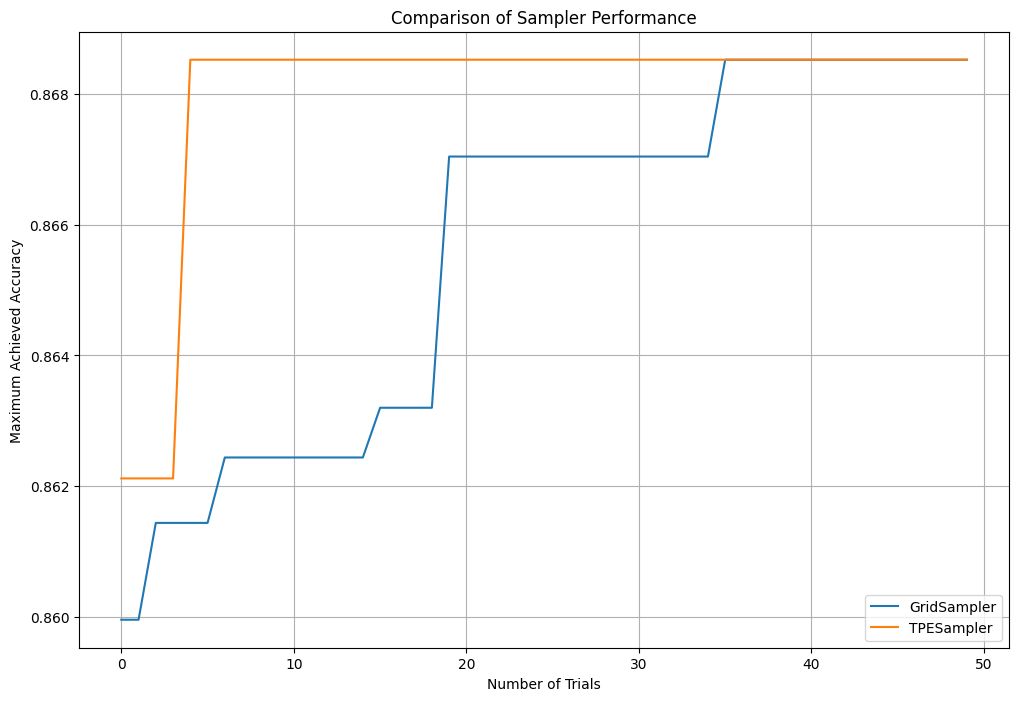

In [ ]:
plt.figure(figsize=(12, 8))

for sampler_name, data in results.items():
    plt.plot(data["trials"], data["best_acc"], label=sampler_name)

plt.xlabel("Number of Trials")
plt.ylabel("Maximum Achieved Accuracy")
plt.title("Comparison of Sampler Performance")
plt.legend()
plt.grid(True)
plt.show()

# Lab 2.2

In [ ]:
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from chop.pipelines import CompressionPipeline
from chop import MaseGraph
from chop.tools import get_tokenized_dataset
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr
import torch
import torch.nn as nn
from chop.tools import get_trainer
from torch.nn import Identity

In [ ]:
# Define the compression-aware objective function (no post-compression training)
def objective_with_compression(trial):
    model = construct_model(trial)


    # Pre-compression training
    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )
    trainer.train()

    # Apply compression
    mg = MaseGraph(
        model.cpu(),
        hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
        ],
    )
    pipe = CompressionPipeline()

    quantization_config = {
        "by": "type",
        "default": {
            "config": {
                "name": None,
            }
        },
        "linear": {
            "config": {
                "name": "integer",
                # data
                "data_in_width": 8,
                "data_in_frac_width": 4,
                # weight
                "weight_width": 8,
                "weight_frac_width": 4,
                # bias
                "bias_width": 8,
                "bias_frac_width": 4,
            }
        },
    }

    pruning_config = {
        "weight": {
            "sparsity": 0.5,
            "method": "l1-norm",
            "scope": "local",
        },
        "activation": {
            "sparsity": 0.5,
            "method": "l1-norm",
            "scope": "local",
        },
    }

    mg, _ = pipe(
        mg,
        pass_args={
            "quantize_transform_pass": quantization_config,
            "prune_transform_pass": pruning_config,
        },
    )

    trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
    num_train_epochs=0, # no post-training
    ) # Used to put all the data into cpu

    # Evaluate after compression (no post-training)
    eval_results = trainer.evaluate()
    return eval_results["eval_accuracy"]


################################################################################
# Define the compression-aware objective function (with post-compression training)
def objective_with_post_compression_training(trial):
    model = construct_model(trial)

    # Pre-compression training
    trainer = get_trainer(
        model=model.cpu,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )
    trainer.train()

    # Apply compression
    mg = MaseGraph(
        model.cpu(),
        hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
        ],
    )

    pipe = CompressionPipeline()

    quantization_config = {
        "by": "type",
        "default": {
            "config": {
                "name": None,
            }
        },
        "linear": {
            "config": {
                "name": "integer",
                # data
                "data_in_width": 8,
                "data_in_frac_width": 4,
                # weight
                "weight_width": 8,
                "weight_frac_width": 4,
                # bias
                "bias_width": 8,
                "bias_frac_width": 4,
            }
        },
    }

    pruning_config = {
        "weight": {
            "sparsity": 0.5,
            "method": "l1-norm",
            "scope": "local",
        },
        "activation": {
            "sparsity": 0.5,
            "method": "l1-norm",
            "scope": "local",
        },
    }


    compressed_model, _ = pipe(
        mg,
        pass_args={
            "quantize_transform_pass": quantization_config,
            "prune_transform_pass": pruning_config,
        },
    )

    # Post-compression training
    post_trainer = get_trainer(
        model=compressed_model.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=2,
    )
    post_trainer.train()
    eval_results = post_trainer.evaluate()
    return eval_results["eval_accuracy"]

In [ ]:
number_trials  = 30

results = {}

# Compression-aware studies
sampler = TPESampler()
studies = {
    "With Compression (No Post-Training)": optuna.create_study(direction="maximize", sampler=sampler),
    "With Compression (Post-Training)": optuna.create_study(direction="maximize", sampler=sampler),
}

# Optimize each study
for label, study in studies.items():
    if label == "With Compression (No Post-Training)":
        study.optimize(objective_with_compression, n_trials=number_trials)
    elif label == "With Compression (Post-Training)":
        study.optimize(objective_with_post_compression_training, n_trials=number_trials)

    results[label] = {
        "trials": [t.number for t in study.trials],  # Trial numbers
        "best_acc": [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]  # Best accuracy progression
    }

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
results['Without Compression'] =  {'trials': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
                          'best_acc': [0.85996, 0.85996, 0.86144, 0.86144, 0.86144, 0.86144, 0.86244, 0.86244, 0.86244, 0.86244, 0.86244, 0.86244, 0.86244, 0.86244, 0.86244, 0.8632, 0.8632, 0.8632, 0.8632, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852]}



{'TPESampler': {'trials': [0], 'best_acc': [0.81484]}, 'With Compression (No Post-Training)': {'trials': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'best_acc': [0.7178, 0.73976, 0.7558, 0.7558, 0.7558, 0.77172, 0.77172, 0.77172, 0.77172, 0.77172, 0.77172, 0.77172, 0.77172, 0.77176, 0.77176, 0.80312, 0.80316, 0.80316, 0.81276, 0.81276, 0.81276, 0.81276, 0.81276, 0.81276, 0.81276, 0.81276, 0.81276, 0.81276, 0.81276, 0.81276]}, 'With Compression (Post-Training)': {'trials': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'best_acc': [0.86776, 0.86776, 0.86776, 0.87196, 0.87196, 0.87196, 0.87196, 0.87196, 0.87196, 0.87196, 0.87196, 0.87196, 0.87196, 0.87196, 0.87196, 0.87196, 0.87216, 0.87216, 0.87216, 0.87216, 0.87216, 0.87216, 0.87248, 0.87248, 0.87248, 0.87248, 0.87248, 0.87248, 0.87248, 0.87248]}, 'Without Compression': {'trials': [0, 1, 2, 3, 4, 5, 6, 7,

In [ ]:
# Get the last item
last_key, last_value = results.popitem()

# Reconstruct the dictionary with the last item first
results = {last_key: last_value, **results}
print(results)

{'Without Compression': {'trials': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'best_acc': [0.85996, 0.85996, 0.86144, 0.86144, 0.86144, 0.86144, 0.86244, 0.86244, 0.86244, 0.86244, 0.86244, 0.86244, 0.86244, 0.86244, 0.86244, 0.8632, 0.8632, 0.8632, 0.8632, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86704, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852, 0.86852]}, 'With Compression (No Post-Training)': {'trials': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'best_acc': [0.7178, 0.73976, 0.7558, 0.7558, 0.7558, 0.77172, 0.77172, 0.77172, 0.77172, 0.77172, 0.77172, 0.77172, 0.77172, 0.77176, 0.77176, 0.8031

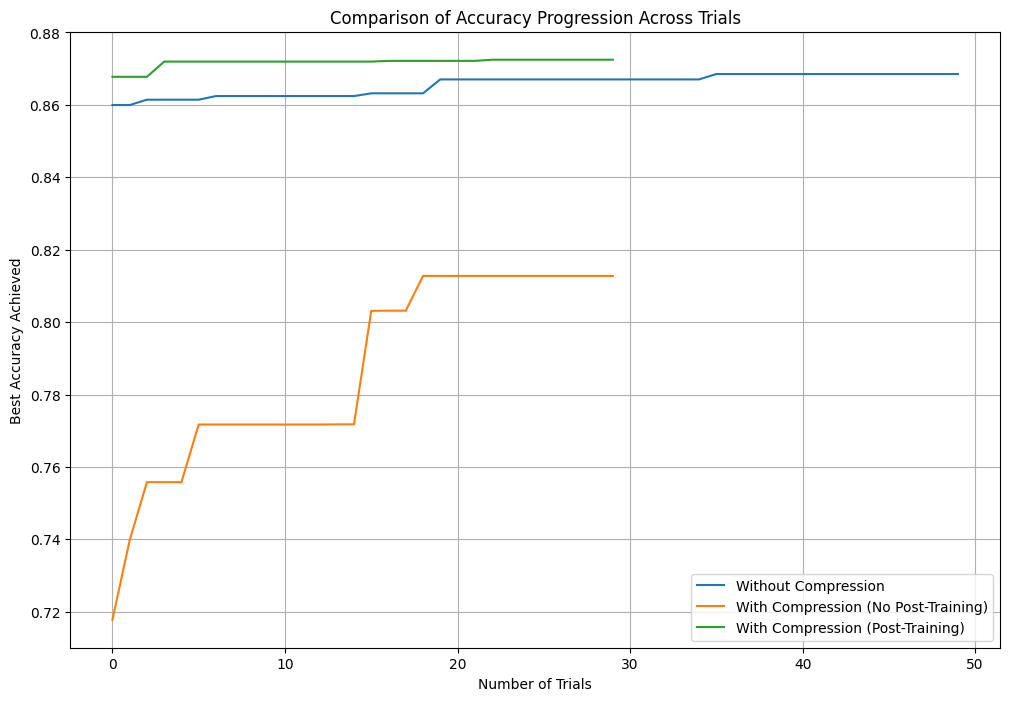

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

for label, data in results.items():
    plt.plot(data["trials"], data["best_acc"], label=label)

plt.title("Comparison of Accuracy Progression Across Trials")
plt.xlabel("Number of Trials")
plt.ylabel("Best Accuracy Achieved")
plt.legend()
plt.grid()
plt.show()
